# Project 9 - Prédisez la demande en électricité
Python, regression lineaire, modélisations de séries temporelles (AR, MA, ARMA, ARIMA, etc.)

Scenario

You work for Enercoop France, company that specialises in renewable energy.

Due to intermittent nature of energy supply and demand, we need to figure out a way to predict demand in order to be able to give adequate supply.

In [1]:
workdir = 'C:/Users/aciag/Desktop/IDF OpenClassrooms/P9_MM' # instead of os module

# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
import seaborn as sns
%matplotlib inline

# pandas settings
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)

import os

import statsmodels.formula.api as smf
import pingouin as pg
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import *
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

### Electricity data

In [2]:
# importer les données
# import data
df = pd.read_csv(workdir + '/data/eCO2mix_RTE_energie_M.csv', sep=',', encoding='latin3', index_col=0, parse_dates=[0])
df.head(5)

# latin3 encoding only (french special symbols)
# index_col + parse_dates to manipulate datetime col into index and proper format

,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
Mois,,,,,,,,,,,,,,,,,,,,,
2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,1587,125,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
2012-02-01,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,1123,216,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2012-03-01,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,977,356,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
2012-04-01,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,1572,329,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
2012-05-01,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,974,454,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [3]:
print((df.isna().sum()/df.shape[0]*100).round(2))
print('')
print(df.duplicated().sum())

Qualité                                      0.00
Territoire                                   0.00
Production totale                            0.00
Production nucléaire                        34.93
Production thermique totale                  0.00
Production thermique charbon                30.58
Production thermique fioul                   0.00
Production thermique gaz                     0.00
Production hydraulique                       0.00
Production éolien                            0.00
Production solaire                           0.00
Production bioénergies                       0.00
Consommation totale                          0.00
Solde exportateur                            5.99
Echanges export                             91.30
Echanges import                             91.30
Echanges avec le Royaume-Uni                91.30
Echanges avec l'Espagne                     91.30
Echanges avec l'Italie                      91.30
Echanges avec la Suisse                     91.30


Grand pourcentage de valeurs manquantes dans certaines colonnes, mais elles ne semblent pas importantes.
Le cadre de données n'a pas de valeurs dupliquées.

Big percentage of missing values in certain columns, but they don't look important.
Dataframe has no duplicated values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1403 entries, 2012-01-01 to 2021-11-01
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Qualité                                   1403 non-null   object 
 1   Territoire                                1403 non-null   object 
 2   Production totale                         1403 non-null   int64  
 3   Production nucléaire                      913 non-null    float64
 4   Production thermique totale               1403 non-null   int64  
 5   Production thermique charbon              974 non-null    float64
 6   Production thermique fioul                1403 non-null   int64  
 7   Production thermique gaz                  1403 non-null   int64  
 8   Production hydraulique                    1403 non-null   int64  
 9   Production éolien                         1403 non-null   int64  
 10  Production solaire

In [5]:
df.Territoire.unique()

array(['France', 'Grand-Est', 'Nouvelle-Aquitaine',
       'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Ile-de-France', 'Occitanie', 'Normandie',
       'Hauts-de-France', 'PACA', 'Pays-de-la-Loire'], dtype=object)

In [6]:
df.Territoire.value_counts()

France                     119
Auvergne-Rhône-Alpes       107
Normandie                  107
Hauts-de-France            107
Bourgogne-Franche-Comté    107
Grand-Est                  107
PACA                       107
Pays-de-la-Loire           107
Ile-de-France              107
Nouvelle-Aquitaine         107
Centre-Val de Loire        107
Occitanie                  107
Bretagne                   107
Name: Territoire, dtype: int64

La dataframe est divisée en régions, mais contient également des données globales pour l'ensemble du pays (France).

Dataframe is split into regions, but also contains overall data for the whole country (France).

In [7]:
# supprimer les régions, consolider les données en tant que France seulement
# remove regions, consolidate data as France only

df = df.loc[df['Territoire'] == 'France']

In [8]:
print((df.isna().sum()/df.shape[0]*100).round(2))

Qualité                                      0.00
Territoire                                   0.00
Production totale                            0.00
Production nucléaire                         0.00
Production thermique totale                  0.00
Production thermique charbon                 0.00
Production thermique fioul                   0.00
Production thermique gaz                     0.00
Production hydraulique                       0.00
Production éolien                            0.00
Production solaire                           0.00
Production bioénergies                       0.00
Consommation totale                          0.00
Solde exportateur                            0.00
Echanges export                              0.00
Echanges import                              0.00
Echanges avec le Royaume-Uni                 0.00
Echanges avec l'Espagne                      0.00
Echanges avec l'Italie                       0.00
Echanges avec la Suisse                      0.00


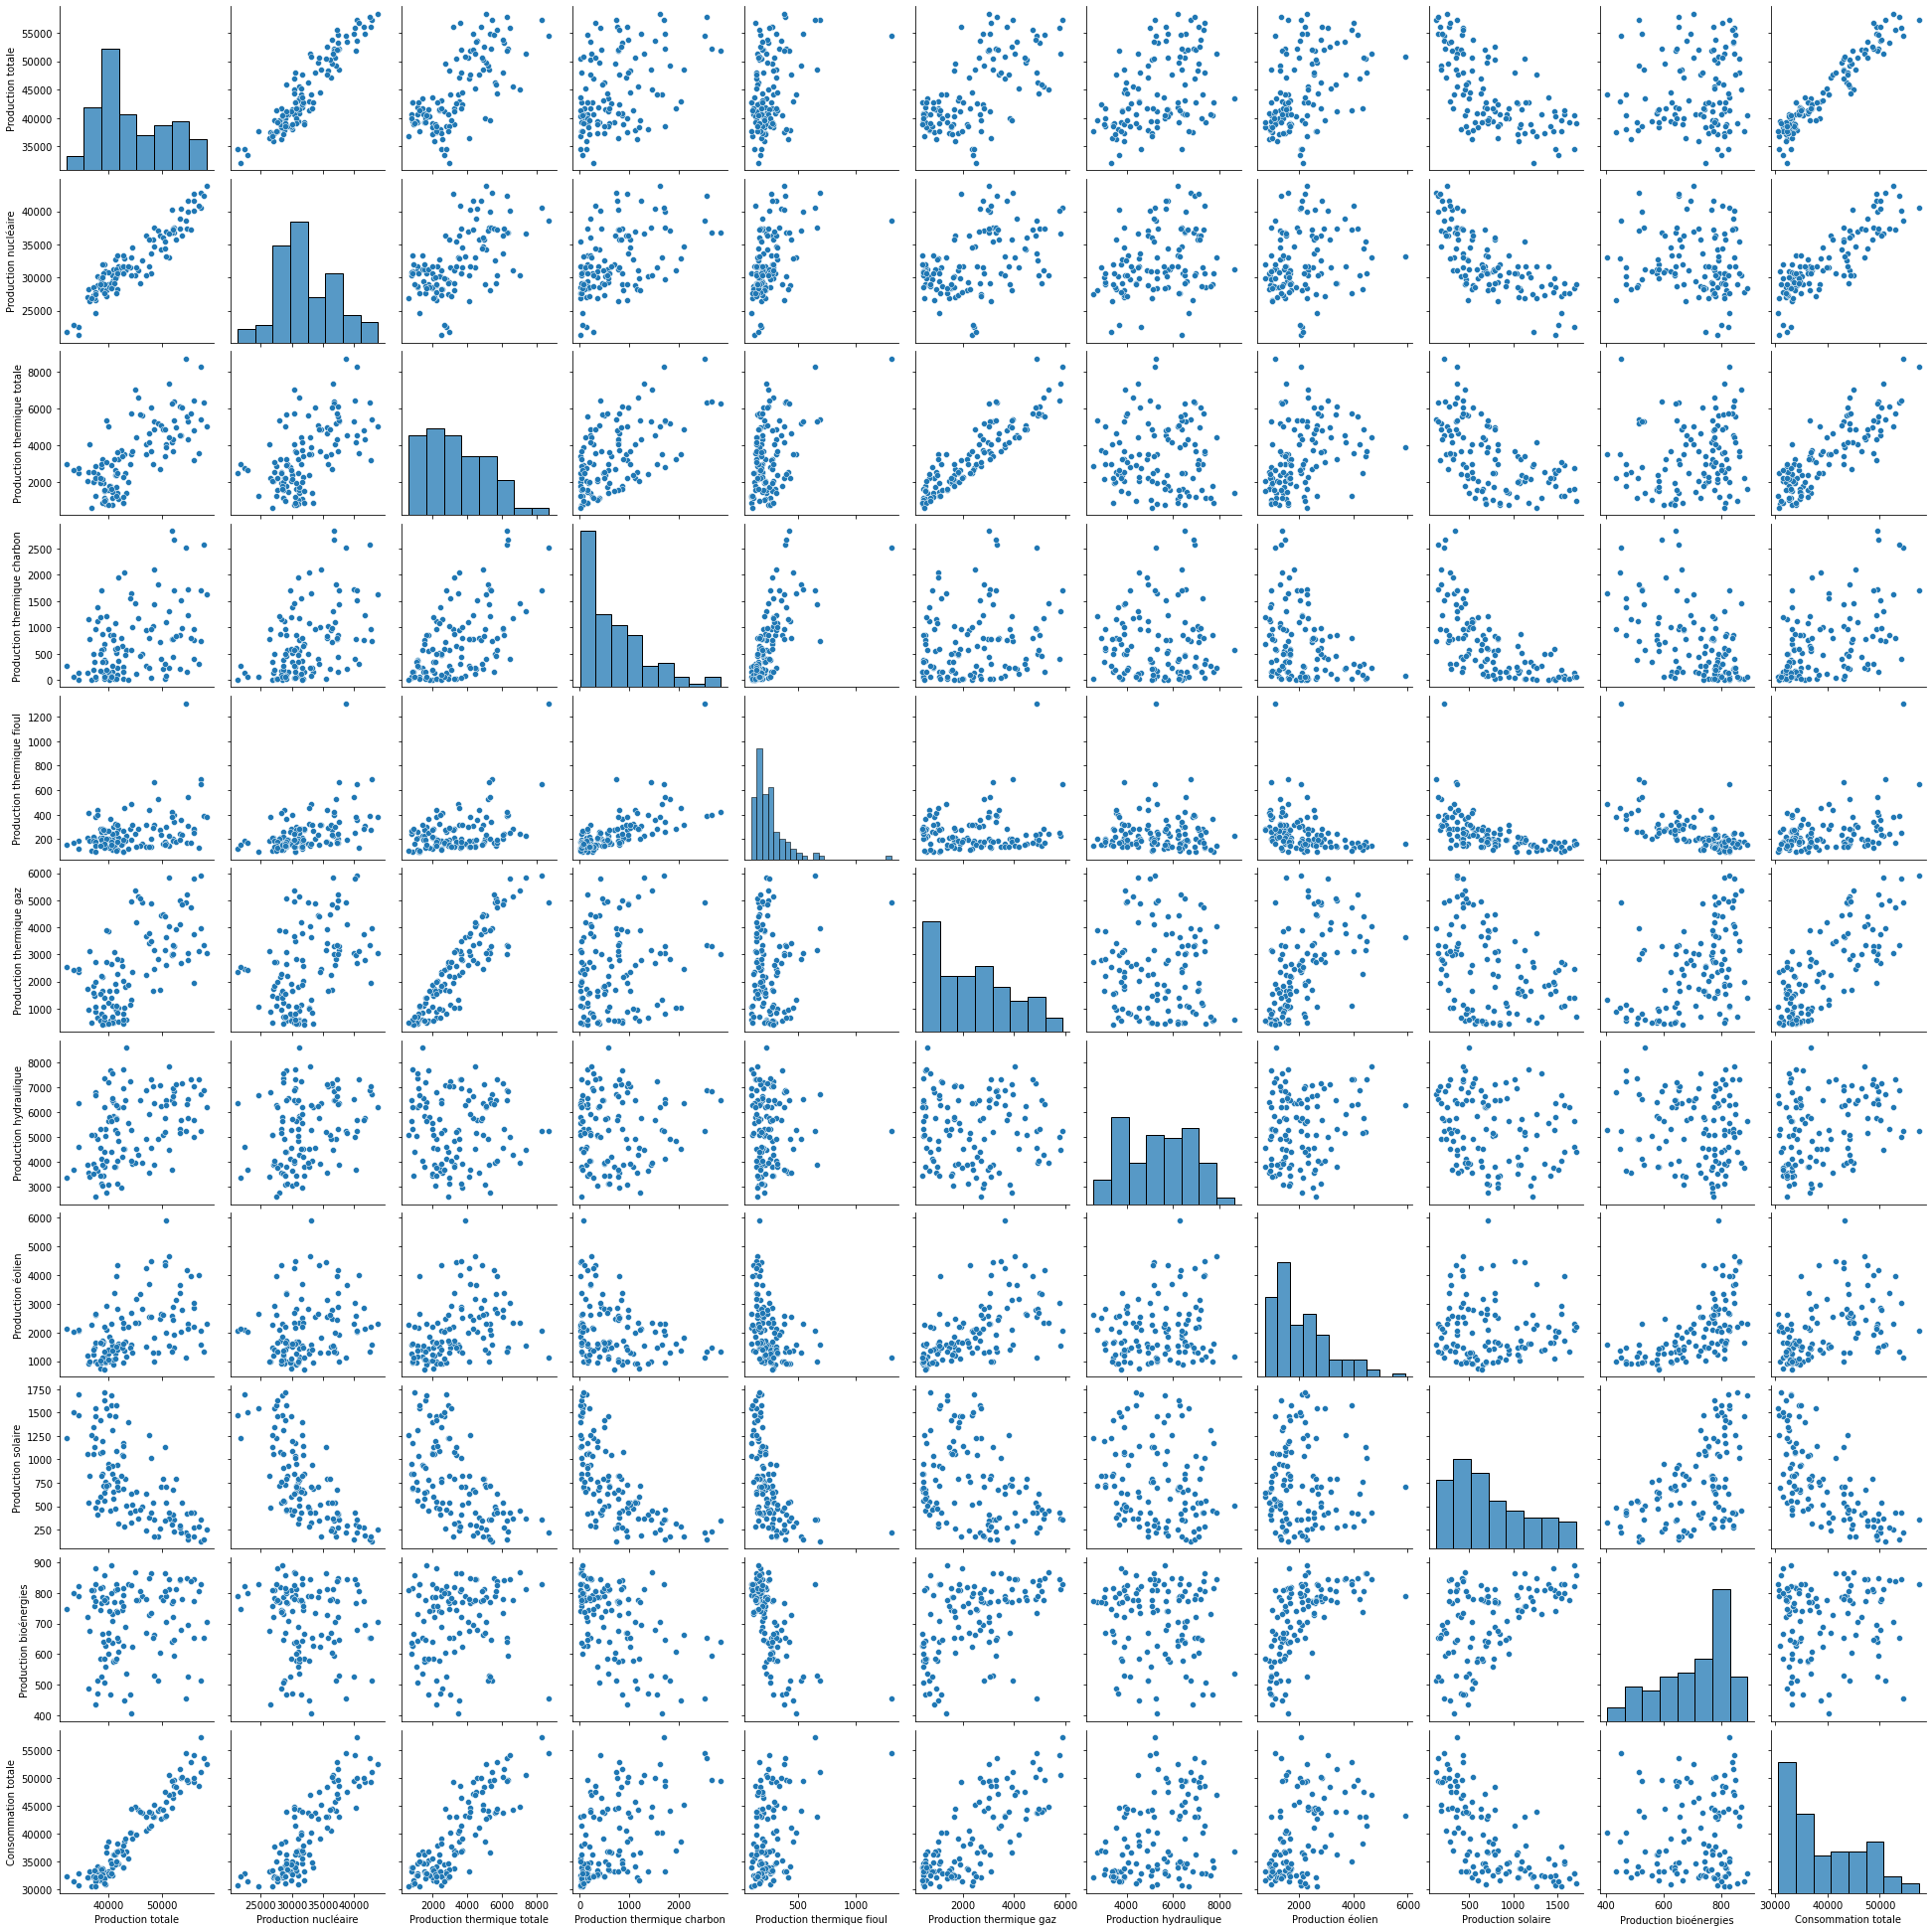

In [9]:
# visualiser les relations entre les principales variables de production et de consommation
# visualize relationships for main variables of production and consumption

sns.pairplot(df.iloc[:,:13], kind='scatter')

plt.savefig(fname=f'Data_relationships.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

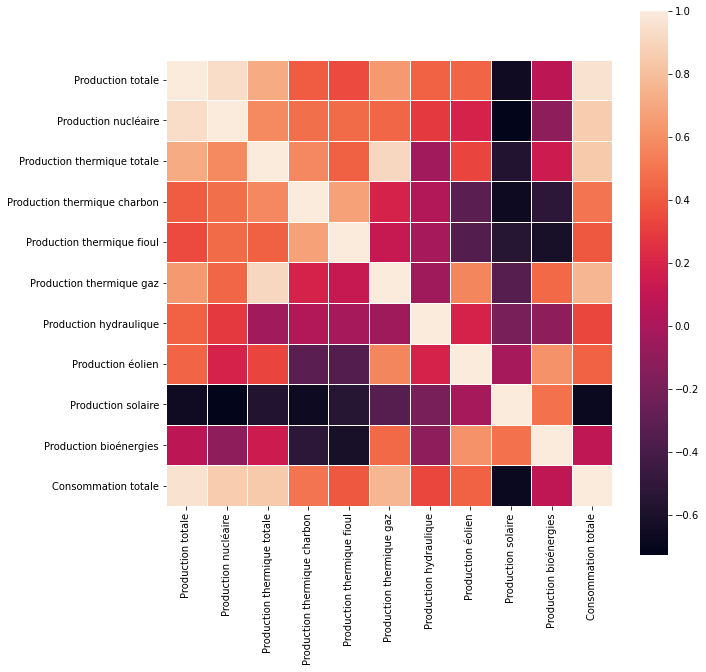

In [10]:
# visualiser les corrélations avec heatmap
# visualize correlations as heatmap

plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[:,:13].corr(), linewidth=1, square=True)

plt.savefig(fname=f'Correlation_heatmap.jpg', dpi=100, format='jpg', bbox_inches='tight')
plt.show();

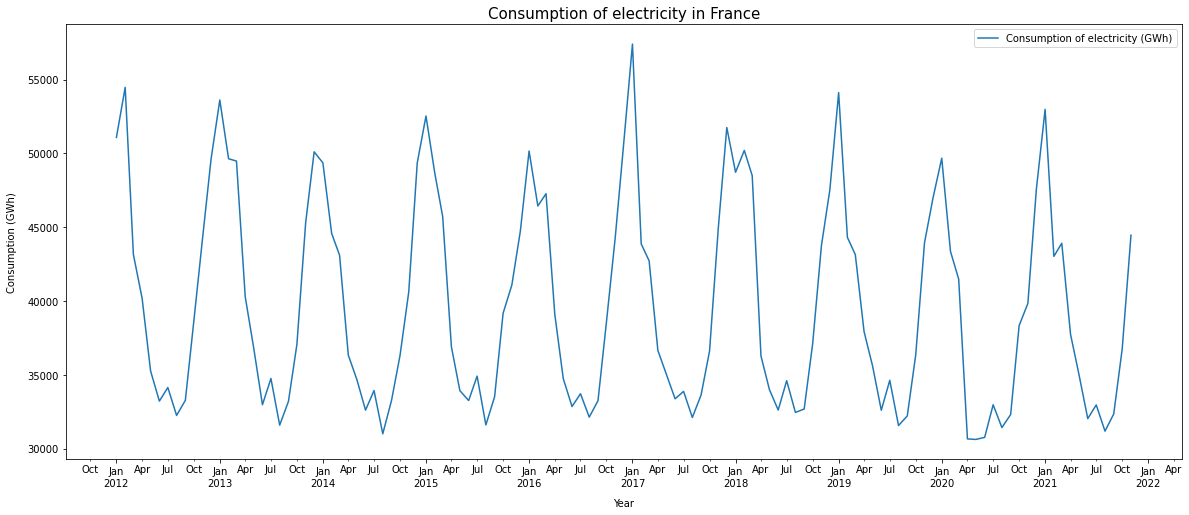

In [11]:
# séries temporelles
# time series

fig, ax = plt.subplots(figsize = (20,8))

sns.lineplot(data = df, x='Mois', y='Consommation totale', ax=ax)

plt.xlabel('Year', labelpad=10)
plt.ylabel('Consumption (GWh)', labelpad=10)
plt.legend(labels=['Consumption of electricity (GWh)'])
plt.title('Consumption of electricity in France', fontsize=15)

locator = mdates.MonthLocator(bymonth=[4,7,10])

ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.savefig(fname=f'Consumption_electricity_France.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')

plt.show();

### Temperature (DJU)
degrés jours unifiés (DJU)

Calculation of unified degree days (UDD)

This tool, developed in partnership with Météo France, allows the calculation of heating or cooling degrees of day (DJ or DJU) for a given period, weather station and temperature threshold.

The degree day is a value representative of the difference between the temperature of a given day and a pre-established temperature threshold (18°C in the case of the DJU or Unified Degree Day). Summed over a period of time, they are used to calculate the heating and cooling needs of a building.

In [12]:
# data downloaded from https://cegibat.grdf.fr/simulateur/calcul-dju
# default parameters
# calculation method - Meteo
# type of usage - Heating
# reference temperature - 18 degrees Celcius

#xlsx files with calcul_DJU name

dju = pd.read_excel(workdir + '/data/calcul_DJU_19_03_2022.xlsx', header=11, index_col=0)

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [13]:
dju

,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
2021,396.7,302.8,271.0,228.3,138.3,1.4,0.0,0.0,0.0,0.0,0.0,0.0,1338.2
2020,339.0,249.6,268.6,81.4,65.7,20.6,0.9,4.5,34.3,157.5,227.2,336.8,1785.9
2019,404.9,268.3,233.1,168.5,117.9,24.4,0.0,1.7,26.7,133.7,282.6,327.3,1989.0
2018,303.4,432.6,314.3,119.7,55.9,8.1,0.0,3.3,34.3,122.4,282.5,325.9,2002.2
2017,467.9,278.4,206.1,182.6,75.0,9.4,1.0,6.8,62.6,99.4,282.6,369.0,2040.6
2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8,2207.3
2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1,1986.2
2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2,1811.5
2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5,2424.8
2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9,2191.5


In [14]:
# créer une liste de tous les fichiers avec le masque calcul_DJU
# create a list of all files with calcul_DJU mask

files = [file for file in os.listdir(workdir + '/data/') if file.startswith('calcul_DJU')]

for file in files:
    print(file)

calcul_DJU_19_03_2022(1).xlsx
calcul_DJU_19_03_2022(2).xlsx
calcul_DJU_19_03_2022(3).xlsx
calcul_DJU_19_03_2022(4).xlsx
calcul_DJU_19_03_2022(5).xlsx
calcul_DJU_19_03_2022(6).xlsx
calcul_DJU_19_03_2022(7).xlsx
calcul_DJU_19_03_2022.xlsx


In [15]:
# concattez tous les dfs des fichiers en un seul cadre de données.
# concat all dfs from files into one single dataframe
dju = pd.DataFrame()

for file in files:
    data = pd.read_excel(workdir + '/data/' + file, header=11, index_col=0)
    dju = pd.concat((dju,data))
    
# supprimer les caractères spéciaux pour une manipulation plus facile dans le futur
# remove special chars for easier handling in the future
dju = dju.rename(columns={'FÉV':'FEV', 'AOÛ':'AOU', 'DÉC':'DEC'})

# somme et moyenne par an
# sum and average per year
dju = dju.groupby(dju.index).mean() # avg by year
#dju = dju.iloc[:-1,:] # remove year 2021 that lacks half of data
dju

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,JAN,FEV,MAR,AVR,MAI,JUN,JUI,AOU,SEP,OCT,NOV,DEC,Total
2009,468.7125,360.6250,303.3125,176.4875,74.0125,30.4750,8.4500,6.2625,33.7375,153.3000,221.0375,396.7000,2232.8750
2010,491.0000,372.2125,316.4625,182.5500,146.4625,31.5250,2.0625,16.2375,68.6625,180.3750,299.3125,486.9750,2593.5375
2011,408.4125,312.7625,266.1125,109.2250,59.4125,38.3750,21.6625,15.1375,27.0750,126.2875,207.5875,321.6625,1913.4375
2012,366.8125,475.4000,235.6375,232.0625,92.9250,33.2875,16.6250,4.7250,57.0125,137.4000,277.9250,346.8500,2276.3500
2013,418.5000,398.1375,337.0125,219.9875,172.6125,48.4375,1.3250,6.5500,39.9500,96.7125,308.9625,371.7500,2419.7125
2014,321.5875,287.5500,262.4375,160.2375,115.6500,19.1125,7.7250,22.9125,25.4875,83.6750,206.6500,372.5875,1885.3500
2015,392.8125,372.9875,279.9250,157.5875,92.8875,17.4000,7.6125,8.4750,73.0000,181.6875,207.7375,268.8750,2060.7750
2016,343.3750,313.4500,319.3125,216.3375,103.5500,28.5250,9.5375,7.0000,19.5375,181.2375,276.5000,392.1500,2210.2500
2017,474.3250,274.8250,221.2750,206.8375,80.9500,12.3625,3.3625,11.7500,67.9375,106.4125,304.4125,375.8500,2140.0500
2018,298.1500,409.4125,298.8250,131.7750,72.1500,9.1000,0.3125,6.6500,27.9500,130.8500,263.3125,325.5875,1973.8375


In [16]:
# Pivoter les données dans un tableau avec Y et M comme colonnes. 
# pivot data into table with both Y and M as columns 
dju = pd.DataFrame(dju.stack()).reset_index()

# convertir la colonne dtype int en obj
# convert dtype column int to obj
dju['level_0'] = dju['level_0'].astype(object)

# échanger le format str pour la colonne M en datetime
# swap str format for M column into datetime
dju['level_1'] = dju['level_1'].replace({'JAN' : 1, 'FEV' : 2, 'MAR' : 3,
                                         'AVR' : 4, 'MAI' : 5, 'JUN' : 6, 
                                         'JUI' : 7, 'AOU' : 8, 'SEP' : 9,
                                         'OCT' : 10, 'NOV' : 11, 'DEC' : 12})

# fusionner les données des colonnes Y et M dans une nouvelle colonne pour des manipulations correctes de la date.
# merge data from Y and M columns into a new one for proper datetime manipulations
dju['Mois'] = 0

for i in range(0, len(dju)) : 
    dju.loc[i, 'Mois'] = str(dju['level_0'][i]) + ' - ' + str(dju['level_1'][i])
    i += 1
    
# supprimer les données totales
# delete total data
dju = dju[dju['level_1'] != 'Total']

# définir format datetime correcte
# set proper datetime
dju['Mois'] = dju['Mois'].astype('datetime64').copy()

# supprimer les colonnes redondantes et renommer la colonne de données en DJU
# delete redundant columns and rename data col into DJU
dju = dju[['Mois', 0]].rename(columns={0 : 'DJU'})

# fusionner les données DJU et le df principal avec les données d'électricité
# merge DJU data and main df with electricity data
df = df.merge(dju, on='Mois', how='left')
df = df.set_index('Mois')

# supprimer 5 lignes pour la fin de 2021 où les données sont manquantes. Peut-être supprimer toute l'année ou remplir comme des moyennes
# drop 5 lines for the end of 2021 where data is missing. Maybe delete all year or fill as averages
df = df[:-5]

In [17]:
# réorganiser les colonnes pour une meilleure visibilité
# reorder the columns for better visibility
df2 = df.copy()

df = df2[["Qualité", "Territoire", "Production totale", "Consommation totale", "DJU",
          "Production nucléaire", "Production thermique totale", "Production thermique charbon",
          "Production thermique fioul", "Production thermique gaz", 
          "Production hydraulique", "Production éolien", "Production solaire",
          "Production bioénergies",  "Solde exportateur",
          "Echanges export", "Echanges import", "Echanges avec le Royaume-Uni",
          "Echanges avec l'Espagne", "Echanges avec l'Italie",
          "Echanges avec la Suisse", "Echanges avec l'Allemagne et la Belgique"]]

#del df2 KEEP copy just in case

df.sample(5)

,Qualité,Territoire,Production totale,Consommation totale,DJU,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,Production solaire,Production bioénergies,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
Mois,,,,,,,,,,,,,,,,,,,,,,
2019-12-01,Données définitives,France,51229,46974,313.3875,32985.0,4424,239.0,150,4033,7877,4659,436,846,3434.0,7117.0,3683.0,920.0,-395.0,1639.0,1488.0,-216.0
2020-11-01,Données consolidées,France,45127,39840,227.4000,31565.0,4448,117.0,139,4191,4502,3173,657,778,4581.0,7491.0,2909.0,986.0,437.0,1957.0,1677.0,NaN
2015-07-01,Données définitives,France,41695,34912,7.6125,33272.0,1382,226.0,315,840,4044,1399,943,654,6055.0,8563.0,2507.0,1366.0,668.0,1522.0,414.0,2084.0
2014-02-01,Données définitives,France,49555,44580,287.5500,36396.0,2699,717.0,277,1704,7108,2484,262,604,4138.0,6705.0,2567.0,1278.0,-633.0,1818.0,1740.0,-66.0
2013-02-01,Données définitives,France,52257,49639,398.1375,36754.0,6357,2667.0,397,3293,6858,1463,230,595,2132.0,5850.0,3718.0,465.0,-306.0,1545.0,1563.0,-1135.0


## Task 1
Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.\
Correct the monthly consumption data for the temperature effect (due to electric heating) using linear regression.


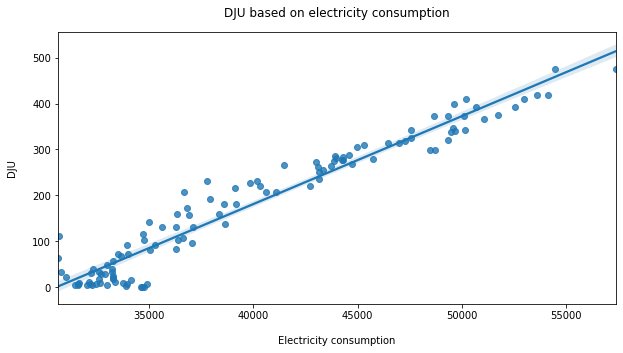

In [18]:
plt.figure(figsize=(10,5))

sns.regplot(x='Consommation totale', y='DJU', data=df)

plt.xlabel('Electricity consumption', labelpad=15)
plt.ylabel('DJU', labelpad=15)
plt.title("DJU based on electricity consumption", pad=15)

plt.savefig(fname=f'DJU_based_on_electricity_consumption.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

In [19]:
# Regression lineare avec statsmodels
# Linear regression with statsmodels
electr_total = df['Consommation totale']
DJU_var = df['DJU']

linreg = smf.ols('electr_total ~ DJU_var', data=df).fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:           electr_total   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     1654.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           6.57e-69
Time:                        18:52:49   Log-Likelihood:                -1014.7
No. Observations:                 114   AIC:                             2033.
Df Residuals:                     112   BIC:                             2039.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.111e+04    271.567    114.544      0.0

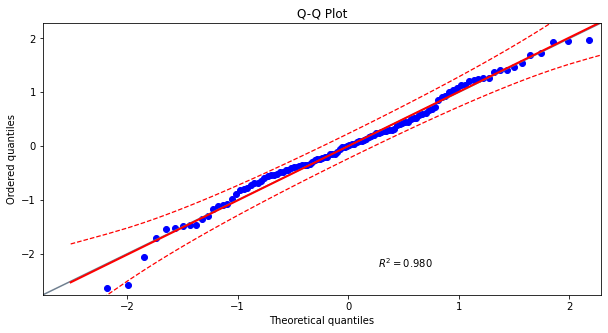

In [20]:
# tests statistiques pour vérifier la performance du modèle
# statistical tests to check performance of the model

pg.qqplot(linreg.resid, figsize=(10,5))

plt.savefig(fname=f'LinRegression_QQplot.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

In [21]:
# https://pingouin-stats.org/generated/pingouin.normality.html

pg.normality(linreg.resid, method='normaltest')

,W,pval,normal
0,5.079996,0.078867,True


In [22]:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html

variables = linreg.model.exog
lm, pval, fval, f_pval = het_breuschpagan(linreg.resid, variables)

print("BreuschPagan test pvalue is:", pval)

# Returns
#    lm - lagrange multiplier statistic
#    lm_pvalue - p-value of lagrange multiplier test
#    fvalue - f-statistic of the hypothesis that the error variance does not depend on x
#    f_pvalue - p-value for the f-statistic

BreuschPagan test pvalue is: 0.7982507332385775


Le graphique QQ donne une représentation visuelle que les résidus suivent de près la distribution normale. Le test de normalité le confirme avec une valeur p de 7% (nous acceptons donc H0 que les données sont normalement distribuées).
Mais le test de variance renvoie une valeur p très élevée de ~80%, ce qui signifie que nous rejetons H0 selon lequel les variances sont constantes (elles ne le sont pas selon ce test).

QQ plot gives visual representation that residuals are closely following normal distribution. Normality test confirms this with pvalue of 7% (thus we accept H0 that data is normally distributed).
But variance test returns very high pvalue of ~80%, meaning we reject H0 that variances are constant (they are not according to this test).

In [23]:
# remettre les valeurs corrigee dans df
# put corrected values back into df
df['Consommation totale corrigee'] = df['Consommation totale'] - (df['DJU'] * linreg.params['DJU_var']).astype(int)

<ipython-input-23-cd6aba354f5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Consommation totale corrigee'] = df['Consommation totale'] - (df['DJU'] * linreg.params['DJU_var']).astype(int)


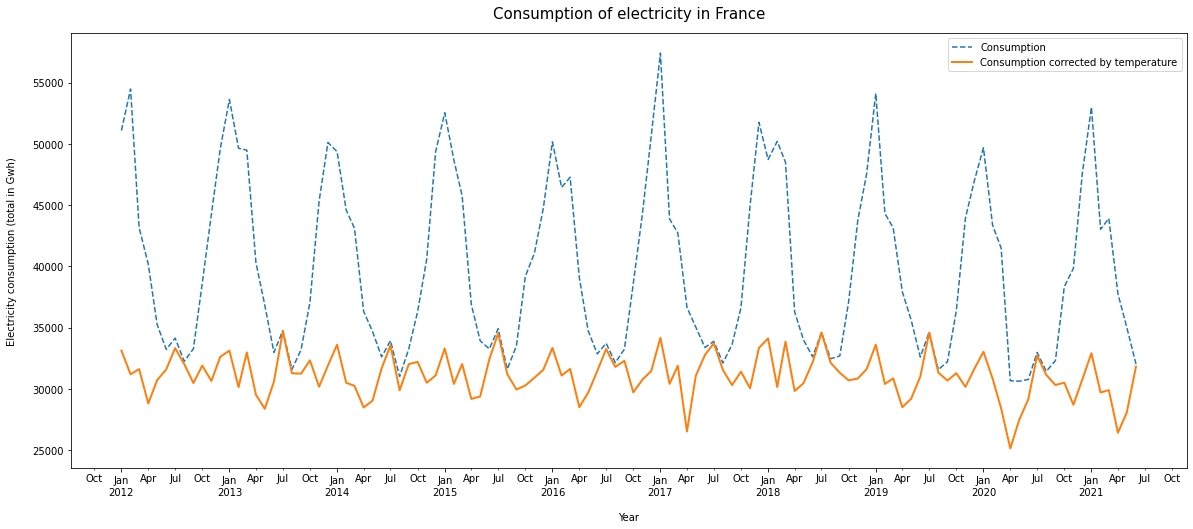

In [24]:
# visualiser les données brutes et corrigées par la consommation de temp
# visualize raw and corrected by temp consumption

fig, ax = plt.subplots(figsize = (20,8))

sns.lineplot(data=df, x='Mois', y='Consommation totale', linestyle='dashed')
sns.lineplot(data=df, x='Mois', y='Consommation totale corrigee', linewidth=2)

plt.xlabel('Year', labelpad=15)
plt.ylabel('Electricity consumption (total in Gwh)', labelpad=15)
plt.legend(labels=['Consumption', 'Consumption corrected by temperature'])

plt.title('Consumption of electricity in France', fontsize=15, pad=15)

locator = mdates.MonthLocator(bymonth=[4,7,10])

ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.savefig(fname=f'Electricity_consumption_TempCorrected.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

## Task 2
Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.\
Perform a seasonal adjustment of the corrected consumption using moving averages.

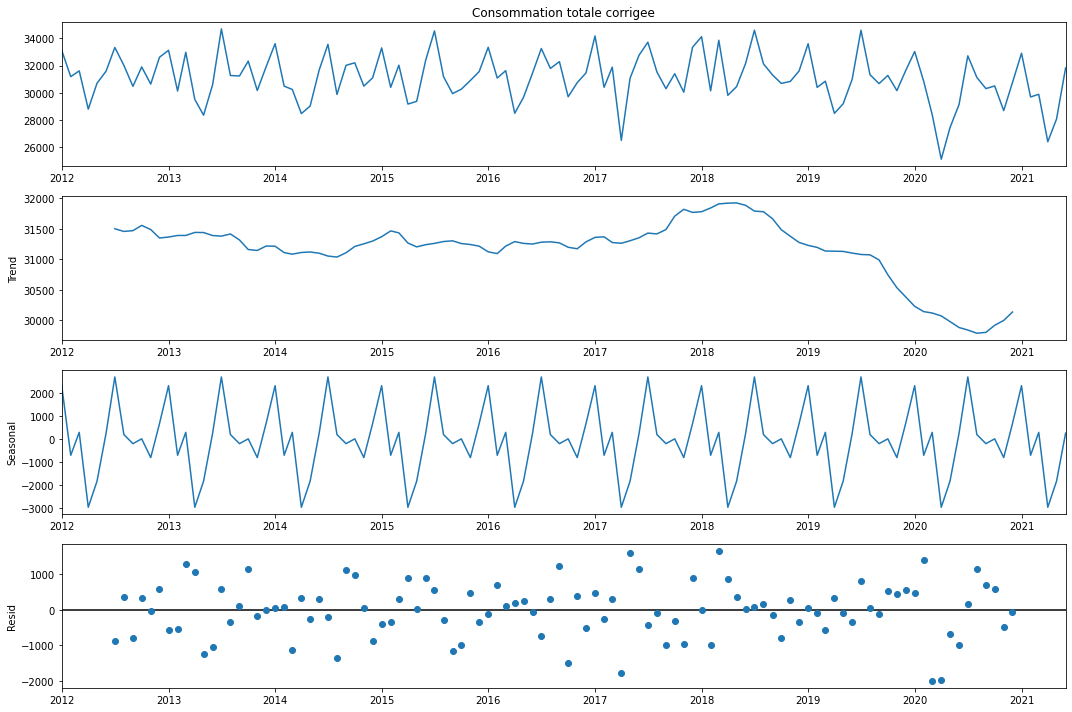

In [25]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
# https://stackoverflow.com/questions/64295560/how-to-use-statsmodels-tsa-seasonal-seasonal-decompose-with-a-pandas-dataframe

electricity = df['Consommation totale corrigee']

decompose = seasonal_decompose(electricity, model='additive')

fig = decompose.plot()
fig.set_size_inches((15, 10))
fig.tight_layout()

plt.savefig(fname=f'Seasonal_decomposition_additive.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

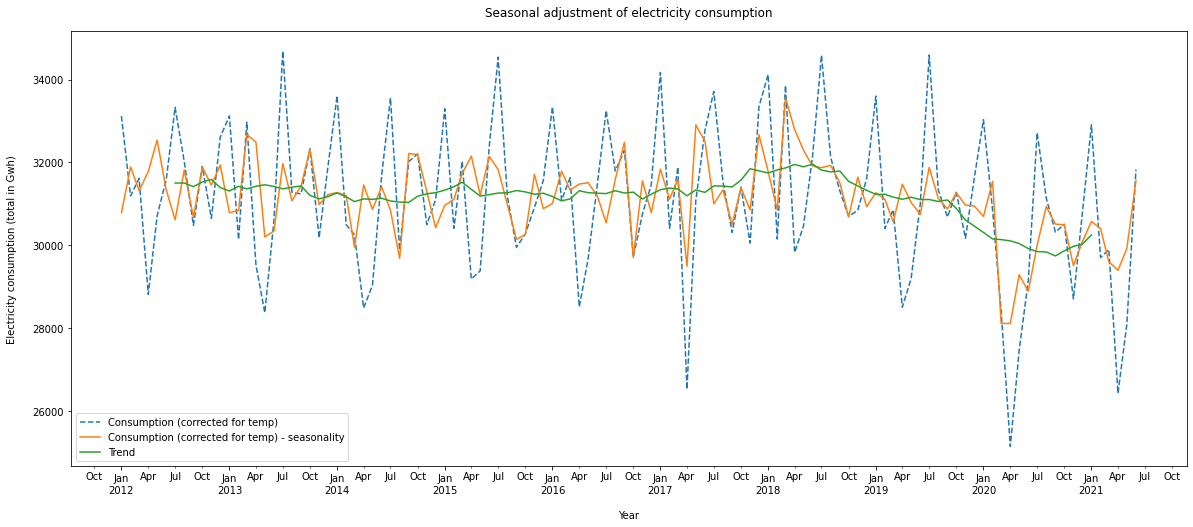

In [26]:
# corr electricity consumption minus seasonal coefficients
# corrigées des variations saisonnières (CVS)
x_cvs = electricity - decompose.seasonal

# saisonnalité de 12 mois
# seasonality of 12 months
electr_seasonality = electricity.rolling(window = 12, center = True).mean()

fig, ax = plt.subplots(figsize = (20,8))

plt.plot(electricity, label='Consumption (corrected for temp)', linestyle='dashed')
plt.plot(x_cvs, label='Consumption (corrected for temp) - seasonality')
plt.plot(electr_seasonality, label='Trend') 

plt.xlabel('Year', labelpad=15)
plt.ylabel('Electricity consumption (total in Gwh)', labelpad=15)
plt.legend()

plt.title('Seasonal adjustment of electricity consumption', pad=15)

locator = mdates.MonthLocator(bymonth=[4,7,10])

ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.savefig(fname=f'Seasonality_of_Electricity_consumption_TempCorrected.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

## Task 3
Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.\
Forecast consumption (corrected for the temperature effect) over one year, using the Holt Winters method (exponential smoothing) and then the SARIMA method on the time series.

### Holt Winters method

In [27]:
# divisé en deux parties, l'une pour l'année dernière et l'autre pour le reste.
# split into separate chunks of data, one last year and everything else

y = electricity[:-12]
y_true = electricity[-12:]

In [28]:
# La méthode de prédiction de Holt Winters
# Holt Winters method of prediction

hw = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


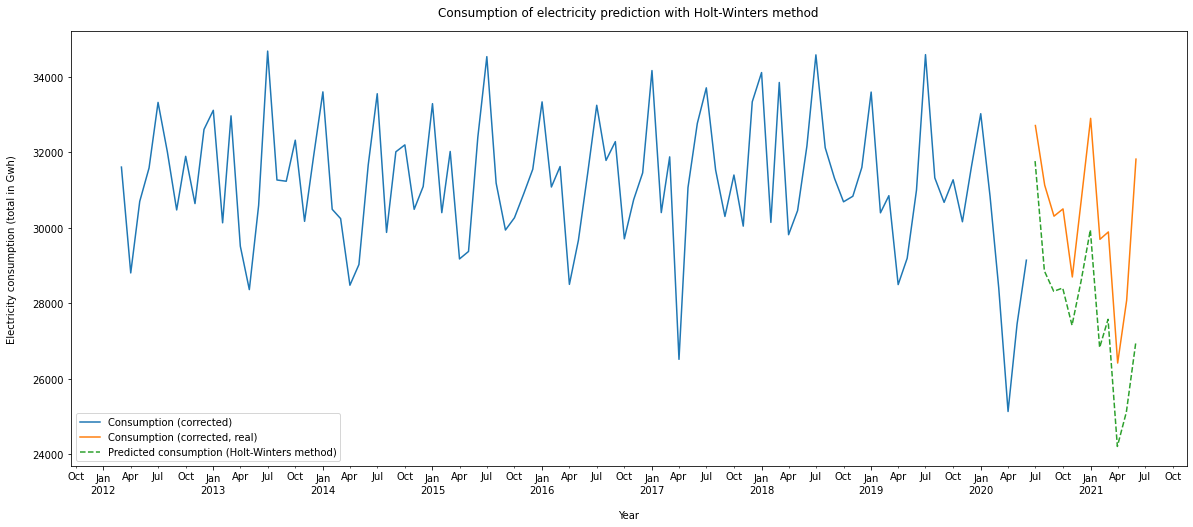

In [29]:
fig, ax = plt.subplots(figsize = (20,8))

plt.plot(y[-100:], label='Consumption (corrected)')
plt.plot(y_true, label='Consumption (corrected, real)')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Predicted consumption (Holt-Winters method)', linestyle='dashed')

plt.xlabel('Year', labelpad=15)
plt.ylabel('Electricity consumption (total in Gwh)', labelpad=15)
plt.legend()

plt.title('Consumption of electricity prediction with Holt-Winters method', pad=15)

locator = mdates.MonthLocator(bymonth=[4,7,10])

ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.savefig(fname=f'Prediction_with_HoltWinters_method.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

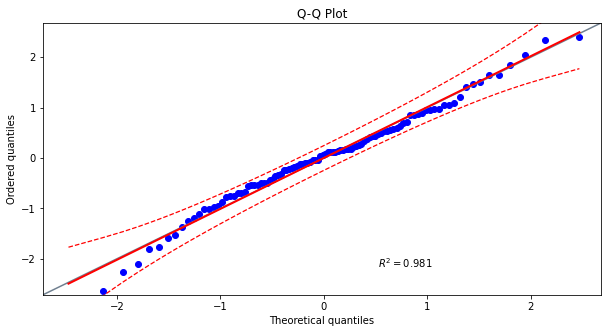

In [30]:
# tests statistiques pour vérifier la performance du modèle
# statistical tests to check performance of the model

pg.qqplot(hw.resid, figsize=(10,5))

plt.savefig(fname=f'HoltWinters_QQplot.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

In [31]:
# https://pingouin-stats.org/generated/pingouin.normality.html

pg.normality(hw.resid, method='normaltest')

,W,pval,normal
0,4.859223,0.088071,True


In [32]:
# metrics
# https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d

# Mean Squared Error
mse = mean_squared_error(y_true, hw_pred)

# Root Mean Square Error
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((y_true - hw_pred) / y_true)) * 100

print('RMSE = ', round(rmse, 2))
print('MAPE = ', round(mape, 2))

RMSE =  2591.62
MAPE =  7.98


Les tests confirment que nos données sont normalement distribuées. Le graphique QQ donne une représentation visuelle, et le test de normalité donne une valeur p de 8% qui confirme H0 (la population est normalement distribuée).\
Tests confirm that our data is normally distributed. QQ plot gives visual representation, and normality test gives pvalue of 8% that confirms H0 (population is normally distributed).

### SARIMA method

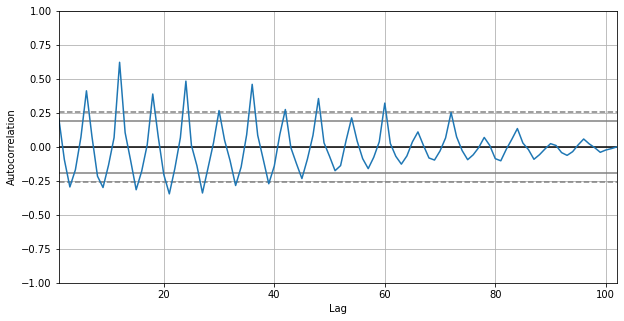

In [33]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html
# https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
# https://neptune.ai/blog/time-series-forecasting
# https://otexts.com/fpp2/seasonal-arima.html
# https://stats.stackexchange.com/questions/129901/sarima-model-equation

plt.figure(figsize=(10,5))

pd.plotting.autocorrelation_plot(y)

plt.savefig(fname=f'Autocorrelation.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

L'autocorrélogramme montre que notre série chronologique n'est pas stationnaire.\
Nous devons atteindre la stationnarité afin d'être en mesure de modéliser les données futures.

Autocorrelogramm shows that our timeseries is not stationary.\
We need to achieve stationarity in order to be able to model future data.

https://towardsdatascience.com/what-is-stationarity-in-time-series-and-why-should-you-care-f3b45082356b

In [34]:
# Dickey Fuller test
adf, p_value, usedlag, nobs, crit_vals, icbest = sm.tsa.stattools.adfuller(y)
round(p_value,2)

# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
#    Returns
#    adf - The test statistic.
#    pvalue - MacKinnon’s approximate p-value based on MacKinnon (1994, 2010).
#    usedlag - The number of lags used.
#    nobs - The number of observations used for the ADF regression and calculation of the critical values.
#    critical values - Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).
#    icbest - The maximized information criterion if autolag is not None.

0.93

We have slow decay towards 0 per autocorrelation plot. As well as DickeyFuller test with pvalue >5% confirms non-Stationarity.\
This gives us a clue to do a differentiation of (I-B).

### Stationarity

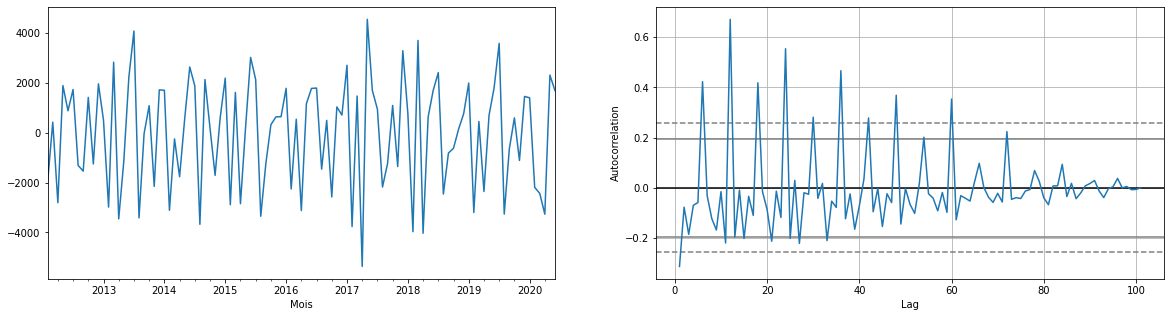

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

# differentiation by order of 1, simple
y_1 = y.diff().dropna() 

# differentiated as time series
y_1.plot(ax = ax1) 

# autocorrelogram for y_1
pd.plotting.autocorrelation_plot(y_1, ax=ax2)

plt.savefig(fname=f'Autocorrelation_d1_simple_diff.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

Autocorrelation again trends towards 0, but we can clearly see seasonal peaks.\
We can try differentiation of (I-B12).

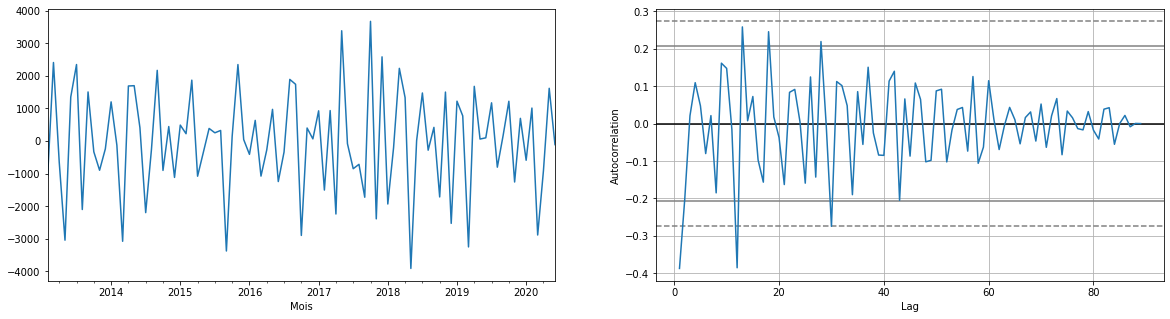

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

# differentiation by order of 12, as a season
y_2 = y_1.diff(periods=12).dropna()

y_2.plot(ax = ax1) 

# autocorrelogram for y_2
pd.plotting.autocorrelation_plot(y_2, ax=ax2)

plt.savefig(fname=f'Autocorrelation_D1_seasonal_diff.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

Le résultat est meilleur ici. Les pics existent toujours, mais les valeurs diminuent plus rapidement et semblent maintenant plus stationnaires.\
Répète le test DF pour confirmer.

Result here is better. Peaks still exist, but values decrease faster and now looks more stationary.\
Repeat DF test to confirm.

In [37]:
# Dickey Fuller test
adf, p_value, usedlag, nobs, crit_vals, icbest = sm.tsa.stattools.adfuller(y_2)
round(p_value, 2)

0.03

La valeur p du test de Dickey Fuller est inférieure à 5%, ce qui signifie que la série temporelle est stationnaire.\
pvalue of Dickey Fuller test is below 5%, which means time series is stationary.

### Finding best model

Le modèle SARIMA prend une différenciation simple + saisonnière avec simpla ARMA, et un processus ARMA via la saisonnalité. Notre période de saisonnalité est de 12 (k). La différenciation simple de 1 (d) et la différenciation saisonnière de 1 (D) nous ont permis de créer des séries temporelles stationnaires. Notre modèle SARIMA ressemblera à (p, 1, q)(P, 1, Q)12. Pour obtenir les meilleures valeurs de q, Q, p, P nous utiliserons l'autocorrélation (autocorrélogrammes). d et D sont les degrés de différenciation utilisés pour stationner la série temporelle. La deuxième partie avec les indicateurs en majuscules correspond à la partie saisonnière de SARIMA et k indique la saisonnalité utilisée.

SARIMA model takes simple + seasonal differentiation with simpla ARMA, and an ARMA process via seasonality. Our seasonality period is 12 (k). Simple differentiation of 1 (d) and seasonal differentiation of 1 (D) helped us create stationary time series. Our SARIMA model will look like (p, 1, q)(P, 1, Q)12. To get the best values of q, Q, p, P we will use autocorrelation (autocorrelograms). d and D are degrees of differentiation used to station the time series. Second part with capitalized indicators corresponds to the seasonal part of SARIMA and k indicates the seasonality used.

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


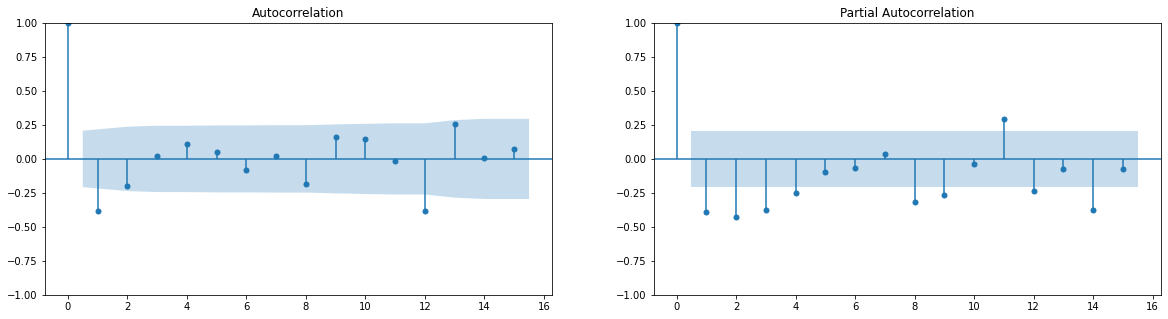

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

plot_acf(y_2, lags=15, ax=ax1)

plot_pacf(y_2, lags=15, ax=ax2)

plt.savefig(fname=f'ACF_PACF.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

In [39]:
model = SARIMAX(y, order=(1,1,1), seasonal_order=(0,1,1,12))

sarima = model.fit(disp=False)

print(sarima.summary())

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:       Consommation totale corrigee   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -774.698
Date:                            Tue, 29 Mar 2022   AIC                           1557.396
Time:                                    18:52:57   BIC                           1567.350
Sample:                                01-01-2012   HQIC                          1561.408
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3198      0.252      1.272      0.204      -0.173       0.813
ma.L1         -0.4825      0.251   

Pvalue pour la 1ère variable (ar.L1) >5%. Cela signifie qu'elle ne contribue pas au modèle et que nous pouvons la supprimer.

Pvalue for 1st variable (ar.L1) >5%. That means it doesnt contribute to the model and we can remove it

In [40]:
# supprimer ar.L1
# remove ar.L1
model = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,1,12))

sarima = model.fit(disp=False)

print(sarima.summary())

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:       Consommation totale corrigee   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -775.541
Date:                            Tue, 29 Mar 2022   AIC                           1557.082
Time:                                    18:52:57   BIC                           1564.548
Sample:                                01-01-2012   HQIC                          1560.092
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1603      0.029     -5.481      0.000      -0.218      -0.103
ma.S.L12      -0.2576      0.046   

https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
The Ljung-Box test is a test for whiteness in residuals. Null hypothesis of this test is: whiteness of the residuals.
\
https://www.statsmodels.org/devel/generated/statsmodels.stats.stattools.jarque_bera.html
The Jarque-Bera test is a normality test. Its H0: the residuals follow a normal distribution.

In [41]:
acorr_ljungbox(sarima.resid, lags=[6, 12, 18, 24, 40, 36], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
6,1.148818,0.979337,1.084400,0.982210
12,19.353771,0.080341,16.890184,0.153775
18,21.888220,0.236986,18.984639,0.392770
24,22.766796,0.533597,19.650404,0.716473
40,26.078474,0.956256,21.902182,0.991114
36,25.741485,0.897429,21.697351,0.971255


Les tests de significativité des paramètres et de blancheur des résidus sont validés au niveau de 5%.

The tests for significance of parameters and whiteness of residuals are therefore validated at the 5% level. 

In [42]:
# normalité des résidus
# residuals normality
pg.normality(sarima.resid, method='normaltest')

# https://pingouin-stats.org/generated/pingouin.normality.html#pingouin.normality
# H0 population is normally distributed

,W,pval,normal
0,130.57699,4.421472e-29,False


Notre valeur p est bien inférieure à 5%, cela signifie que les données ne sont PAS distribuées normalement.

Our pvalue is much lower than 5%, it means that data is NOT normally distributed.

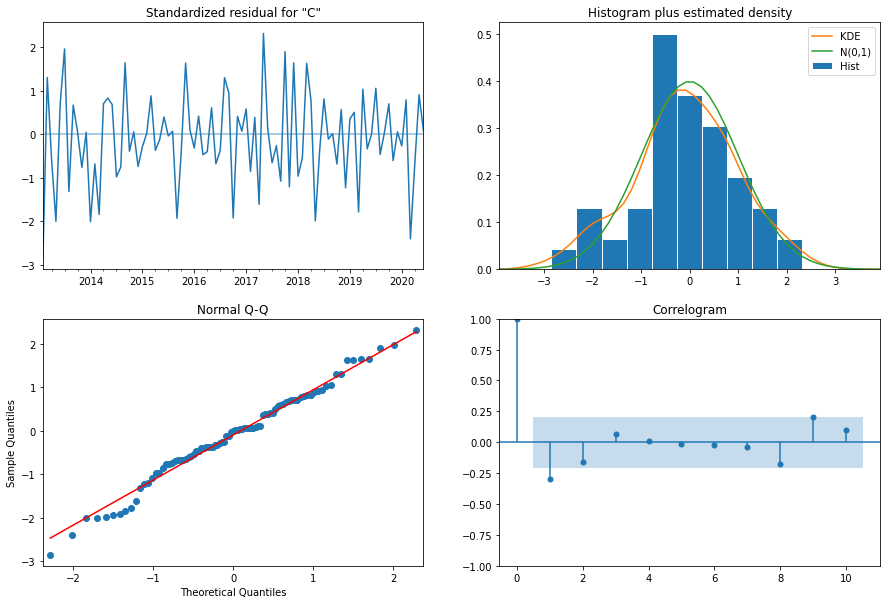

In [43]:
sarima.plot_diagnostics(figsize=(15,10))

plt.savefig(fname=f'SARIMA_diagnostics.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

Les diagnostics SARIMA aident (un bon result est...):\
Résidus normalisés - pas de modèle dans les résidus.\
Histogramme plus densité estimée - ils doivent être proches de la distribution normale.\
QQ normal - aussi proche de la ligne de la distribution normale que possible.\
Corrélogramme - 95 % des points de corrélation qui sont > 0 ne doivent pas être significatifs.

SARIMA diagnostics help (good fit is...):\
Standardized residuals - no patterns in the residuals.\
Histogram plus estimated density - they should be close to normal distribution.\
Normal QQ - as close to the line of normal distribution as possible.\
Correlogram - 95% of correlation points that are > 0 should not be significant.

### Predictions with SARIMA

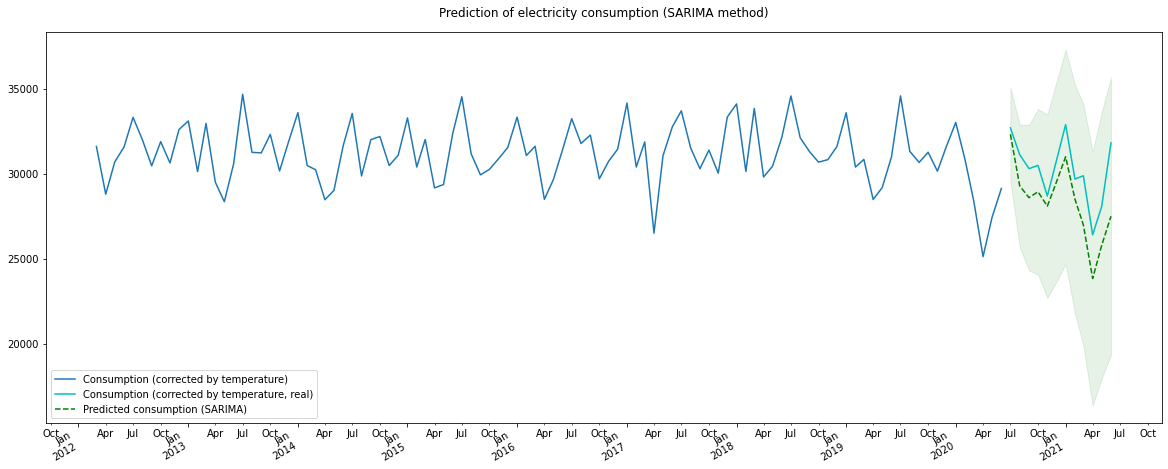

In [44]:
prediction = sarima.get_forecast(steps=12).summary_frame()  

fig, ax = plt.subplots(figsize = (20,8))

plt.plot(y[-100:], label='Consumption (corrected by temperature)')
plt.plot(y_true, label='Consumption (corrected by temperature, real)', color='c')
prediction['mean'].plot(ax=ax, color='g', label='Predicted consumption (SARIMA)', linestyle='dashed') 
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='g', alpha=0.1)
plt.legend(loc='lower left')

plt.title('Prediction of electricity consumption (SARIMA method)', pad=15)

locator = mdates.MonthLocator(bymonth=[4,7,10])

ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.savefig(fname=f'Prediction_with_SARIMA.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show(); 

In [45]:
# metrics
# https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d

# Mean Squared Error
mse = mean_squared_error(y_true, prediction['mean'])

# Root Mean Square Error
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((y_true - prediction['mean']) / y_true)) * 100

print('RMSE = ', round(rmse, 2))
print('MAPE = ', round(mape, 2))

RMSE =  2131.81
MAPE =  6.23


In [46]:
# auto arima model

s_model = auto_arima(y, test='adf', max_p=2,
                     max_q=2, m=12, max_P=2,
                     max_Q=2, seasonal=True, trace=True,
                     error_action='ignore', suppress_warnings=True, stepwise=True,
                     n_jobs=-1, information_criterion='aic')

s_results = s_model.fit(y)

s_resid = pd.Series(s_results.resid(), index=y.index)

print(s_model.summary())

Performing stepwise search to minimize aic


C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1777.509, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1816.136, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1793.275, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1773.709, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2402.863, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1813.011, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1783.052, Time=0.39 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1763.062, Time=0.44 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1777.654, Time=0.70 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1768.476, Time=0.32 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=1765.141, Time=0.66 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=1765.091, Time=0.71 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=1778.417, Time=0.30 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=1767.046, Time=1.04 sec
 ARIMA(0,0,1)(0,0,2)[12]             : AIC=inf, Time=0.83 sec


In [47]:
acorr_ljungbox(s_resid, lags=[6, 12, 18, 24, 40, 36], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
6,5.025071,0.540602,4.699910,0.582837
12,10.133016,0.604292,9.187046,0.686877
18,29.545961,0.042102,25.004871,0.124782
24,42.366639,0.011737,34.884177,0.070137
40,79.780037,0.000187,59.343568,0.024991
36,72.677513,0.000282,55.030471,0.022057


In [48]:
# normalité des résidus
# residuals normality
pg.normality(s_resid, method='normaltest')

,W,pval,normal
0,5.689268,0.058156,True


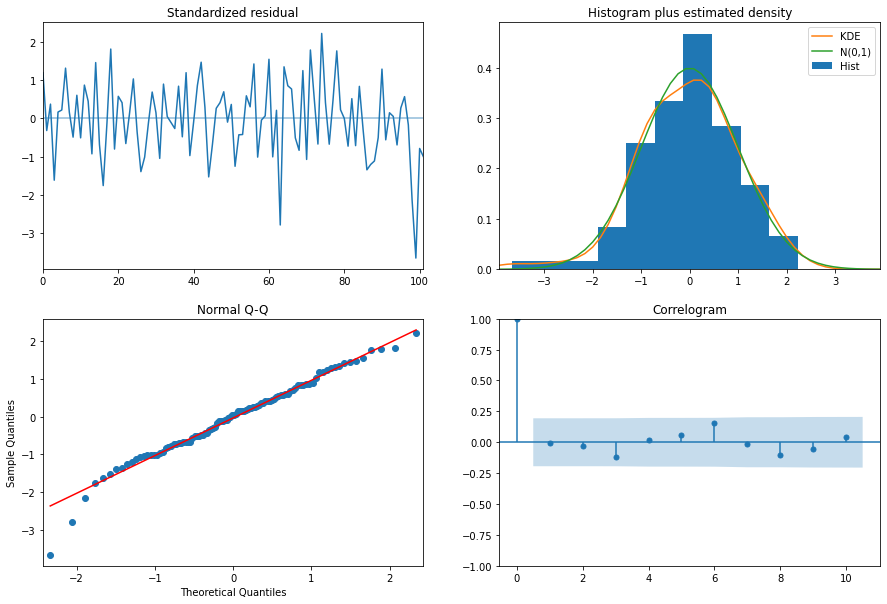

In [49]:
s_results.plot_diagnostics(figsize=(15,10))

plt.savefig(fname=f'AutoSARIMA_diagnostics.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

### Implementing best model from AutoARIMA

In [50]:
# per autoARIMA, best model was determined as ARIMA(0,0,1)(0,0,2)[12] intercept
model = SARIMAX(y, order=(0,0,1), seasonal_order=(0,0,2,12))
sarima = model.fit(disp=False)
print(sarima.summary())

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                        SARIMAX Results                                        
Dep. Variable:            Consommation totale corrigee   No. Observations:                  102
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -1051.277
Date:                                 Tue, 29 Mar 2022   AIC                           2110.554
Time:                                         18:53:09   BIC                           2121.054
Sample:                                     01-01-2012   HQIC                          2114.805
                                          - 06-01-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8911      0.052     17.117      0.000       0.789       0

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


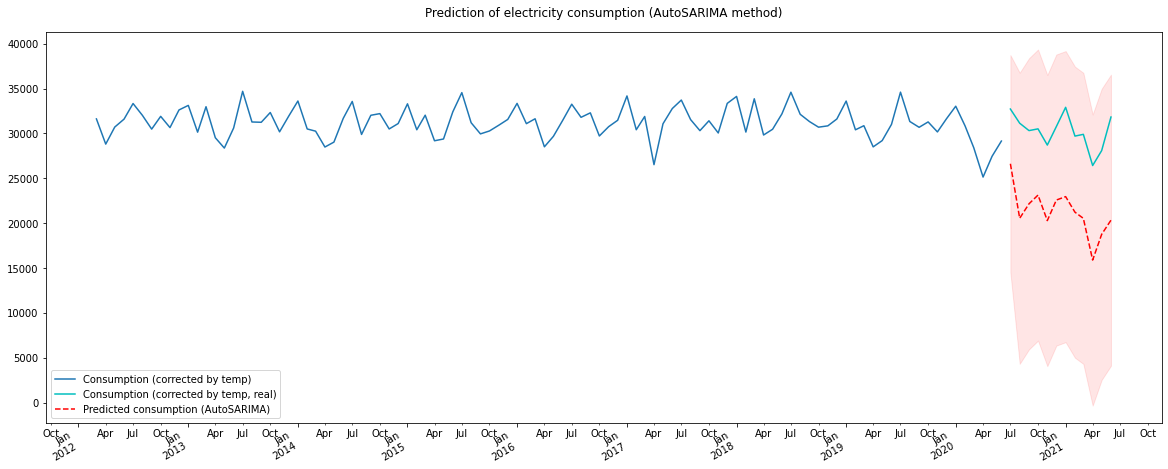

In [51]:
prediction_auto = sarima.get_forecast(steps=12).summary_frame()

fig, ax = plt.subplots(figsize = (20,8))

plt.plot(y[-100:], label='Consumption (corrected by temp)')
plt.plot(y_true, label='Consumption (corrected by temp, real)', color='c')
prediction_auto['mean'].plot(ax=ax, color ='r', label='Predicted consumption (AutoSARIMA)', linestyle='dashed')
ax.fill_between(prediction_auto.index, prediction_auto['mean_ci_lower'], prediction_auto['mean_ci_upper'], color='r', alpha=0.1)
plt.legend(loc='lower left')

plt.title('Prediction of electricity consumption (AutoSARIMA method)', pad=15)

locator = mdates.MonthLocator(bymonth=[4,7,10])

ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.savefig(fname=f'Prediction_with_AutoSARIMA.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

In [52]:
# metrics
# https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d

# Mean Squared Error
mse = mean_squared_error(y_true, prediction_auto['mean'])

# Root Mean Square Error
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((y_true - prediction_auto['mean']) / y_true)) * 100

print('RMSE = ', round(rmse, 2))
print('MAPE = ', round(mape, 2))

RMSE =  9110.38
MAPE =  29.9


Le modèle déterminé par AutoSARIMA comme étant le meilleur donne de moins bons résultats.\
La prédiction est moins précise, et de nombreuses mesures sont bien moins bonnes.

Model determined by AutoSARIMA as best one returns worse results.\
Prediction is less accurate, as well as numerous metrics are much worse.

In [53]:
model = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,2,12))
sarima = model.fit(disp=False)
print(sarima.summary())

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                        SARIMAX Results                                        
Dep. Variable:            Consommation totale corrigee   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -773.598
Date:                                 Tue, 29 Mar 2022   AIC                           1555.196
Time:                                         18:53:10   BIC                           1565.151
Sample:                                     01-01-2012   HQIC                          1559.208
                                          - 06-01-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1569      0.028     -5.679      0.000      -0.211      -0

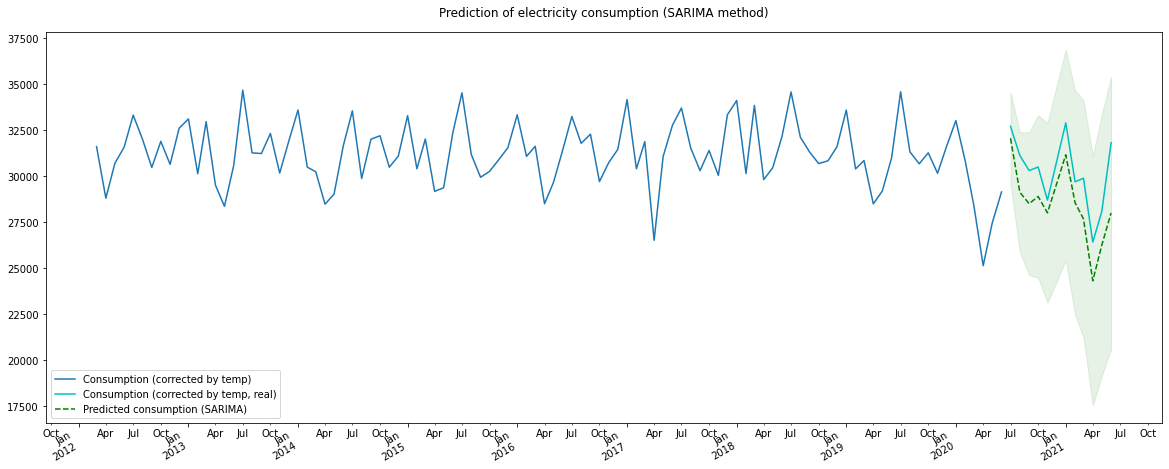

In [54]:
prediction = sarima.get_forecast(steps=12).summary_frame()

fig, ax = plt.subplots(figsize = (20,8))

plt.plot(y[-100:], label='Consumption (corrected by temp)')
plt.plot(y_true, label='Consumption (corrected by temp, real)', color='c')
prediction['mean'].plot(ax=ax, color ='g', label='Predicted consumption (SARIMA)', linestyle='dashed')
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='g', alpha=0.1)
plt.legend(loc='lower left')

plt.title('Prediction of electricity consumption (SARIMA method)', pad=15)

locator = mdates.MonthLocator(bymonth=[4,7,10])

ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.savefig(fname=f'Prediction_with_SARIMA.jpg', dpi=100, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

In [55]:
# metrics
# https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d

# Mean Squared Error
mse = mean_squared_error(y_true, prediction['mean'])

# Root Mean Square Error
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((y_true - prediction['mean']) / y_true)) * 100

print('RMSE = ', round(rmse, 2))
print('MAPE = ', round(mape, 2))

RMSE =  1909.01
MAPE =  5.74


### Comparer les modeles - Compare models

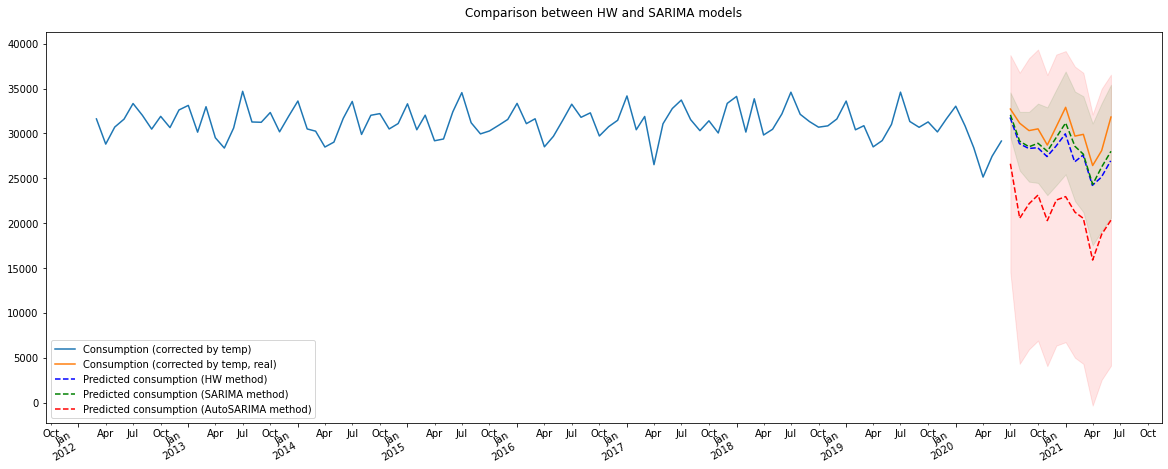

In [56]:
fig, ax = plt.subplots(figsize = (20,8))

plt.plot(y[-100:], label='Consumption (corrected by temp)')
plt.plot(y_true, label='Consumption (corrected by temp, real)')

plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Predicted consumption (HW method)', color='b', linestyle='dashed')

prediction['mean'].plot(ax=ax, color='g', label='Predicted consumption (SARIMA method)', linestyle='dashed') 
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='g', alpha=0.1)

prediction_auto['mean'].plot(ax=ax, color='r', label='Predicted consumption (AutoSARIMA method)', linestyle='dashed') 
ax.fill_between(prediction_auto.index, prediction_auto['mean_ci_lower'], prediction_auto['mean_ci_upper'], color='r', alpha=0.1)

plt.legend()

plt.title("Comparison between HW and SARIMA models", pad=15)

locator = mdates.MonthLocator(bymonth=[4,7,10])

ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

plt.savefig(fname=f'HW_SARIMA_models_comparison.jpg', dpi=300, format='jpg', orientation='landscape', bbox_inches='tight')
plt.show();

## Conclusions générales après l'analyse effectuée

L'utilisation des autocorrélogrammes pour déterminer les modèles SARIMA n'est pas une règle absolue. Elle peut toujours dépendre de la situation. C'est pourquoi les autocorrélogrammes doivent servir d'indicateur utile, en collaboration avec la blancheur des résidus et les degrés de signification. De nombreux modèles peuvent être considérés comme bons après validation de ces paramètres. Dans ce cas, nous pouvons utiliser l'AIC, le BIC, le HQIC donnés par la sortie de SARIMA.
Au vu de notre analyse, nous pouvons dire que le modèle SARIMA donne les meilleurs résultats. Tant sur le plan visuel si nous le comparons aux données réelles, que sur le plan statistique si nous le comparons aux autres modèles.
Si nous devions mettre en œuvre un modèle spécifique, ce serait le modèle SARIMA (ligne pointillée verte).

The use of autocorrelograms to determine SARIMA models is not a strong rule. It can always depend on the situation. Because of this autocorrelograms should serve as a helpful indicator, working together with whiteness of residuals and degrees of significance. Many models can be seen as good after validation of those parameters. In this case we can use AIC, BIC, HQIC given by SARIMA output.
Given our analysis, we can say that SARIMA model yields the best results. Both visually if we compare to the real data, and statistically when we compare metrics with other models.
If we were to put one specific model to work, it would be SARIMA (green dotted line).
